<a href="https://colab.research.google.com/github/ao9mame/ao9mame/blob/main/baseline_000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://zenn.dev/mst8823/articles/da505dcf45474f

In [ ]:
!pip install -Uqq fastbook

import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


## WANDBの設定
https://colab.research.google.com/github/wandb/examples/blob/master/colabs/fastai/Weights_%26_Biases_with_fastai.ipynb#scrollTo=oJeaLRUutMCG

In [ ]:
!pip install -qqq wandb

from fastai.vision.all import *
import wandb
from fastai.callback.wandb import *

     |████████████████████████████████| 1.7 MB 8.1 MB/s 
     |████████████████████████████████| 180 kB 69.4 MB/s 
     |████████████████████████████████| 97 kB 8.6 MB/s 
     |████████████████████████████████| 140 kB 68.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Kaggle設定

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
!pip install -U -q kaggle==1.5.8
!pip install timm

     |████████████████████████████████| 59 kB 4.2 MB/s 
     |████████████████████████████████| 376 kB 7.7 MB/s 


In [ ]:
!kaggle -v

Kaggle API 1.5.8


In [ ]:
from dataclasses import dataclass

@dataclass
class Config:
    name: str = "baseline-001"
    only_inference: bool = False
    model_name: str = "roberta-base"
    learning_rate: float = 1e-5
    max_length: int = 256
    epochs: int = 8
    batch_size: int = 16
    n_fold: int = 5
    seed: int = 2022
    target_col: str = "target"
    debug: bool  = False

    # Colab Env
    upload_from_colab: bool = True
    api_path: str = "/content/drive/MyDrive/kaggle/kaggle.json"
    drive_path: str = "/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest"
    
    # Kaggle Env
    kaggle_dataset_path: str = "../input/petfinder-pawpularity-score"

config = Config()
config

Config(name='baseline-001', only_inference=False, model_name='roberta-base', learning_rate=1e-05, max_length=256, epochs=8, batch_size=16, n_fold=5, seed=2022, target_col='target', debug=False, upload_from_colab=True, api_path='/content/drive/MyDrive/kaggle/kaggle.json', drive_path='/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest', kaggle_dataset_path='../input/petfinder-pawpularity-score')

In [ ]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model
from timm.data.mixup import Mixup

from fastai.vision.all import *
import logging

In [ ]:
class Logger:
    """参考) https://github.com/ghmagazine/kagglebook/blob/master/ch04-model-interface/code/util.py"""
    def __init__(self, path):
        self.general_logger = logging.getLogger(path)
        stream_handler = logging.StreamHandler()
        file_general_handler = logging.FileHandler(os.path.join(path, 'Experiment.log'))
        if len(self.general_logger.handlers) == 0:
            self.general_logger.addHandler(stream_handler)
            self.general_logger.addHandler(file_general_handler)
            self.general_logger.setLevel(logging.INFO)

    def info(self, message):
        # display time
        self.general_logger.info('[{}] - {}'.format(self.now_string(), message))

    @staticmethod
    def now_string():
        return str(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    

def seed_everything(seed=42):
    """参考) https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
COLAB = "google.colab" in sys.modules

In [ ]:
# google colab用設定
if COLAB:
    print("This environment is Google Colab")

    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive') 
	
    # import library
    !pip install --quiet transformers
    !pip install --quiet iterative-stratification
    !pip install --quiet tensorflow-addons

    # use kaggle api (need kaggle token)
    f = open(config.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # set dirs
    DRIVE = config.drive_path
    EXP = (config.name if config.name is not None 
           else get("http://172.28.0.2:9000/api/sessions").json()[0]["name"][:-6])
    INPUT = os.path.join(DRIVE, "Input")
    OUTPUT = os.path.join(DRIVE, "Output")
    SUBMISSION = os.path.join(DRIVE, "Submission")
    OUTPUT_EXP = os.path.join(OUTPUT, EXP) 
    EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    INPUT_DATA_DIR_1 = os.path.join(DRIVE, "Input", "petfinder-pawpularity-score")
    INPUT_DATA_DIR_2 = os.path.join(DRIVE, "Input", "petfinder-pawpularity-score-clean")
    INPUT_DATA_DIR_3 = os.path.join(DRIVE, "Input", "swin-transformer")

    # make dirs
    for d in [INPUT, SUBMISSION, EXP_MODEL, EXP_FIG, EXP_PREDS, INPUT_DATA_DIR_1, INPUT_DATA_DIR_2, INPUT_DATA_DIR_3]:
        os.makedirs(d, exist_ok=True)

    if not os.path.isfile(os.path.join(INPUT_DATA_DIR_1, "train.csv.zip")):
        # load dataset
        ! kaggle competitions download --force --c petfinder-pawpularity-score -p $INPUT_DATA_DIR_1
        ! kaggle datasets download --d schulta/petfinder-pawpularity-score-clean -p $INPUT_DATA_DIR_2
        ! kaggle datasets download -d tanlikesmath/swin-transformer -p $INPUT_DATA_DIR_3
    
    # utils
    logger = Logger(OUTPUT_EXP)
else:
    print("This environment is Kaggle Kernel")
    
    # set dirs
    INPUT = config.kaggle_dataset_path
    EXP, OUTPUT, SUBMISSION = "./", "./", "./"
    EXP_MODEL = os.path.join(EXP, "model")
    EXP_FIG = os.path.join(EXP, "fig")
    EXP_PREDS = os.path.join(EXP, "preds")
    
    # copy dirs
    if config.kaggle_dataset_path is not None:
        KD_MODEL = os.path.join(config.kaggle_dataset_path, "model")
        KD_EXP_PREDS = os.path.join(config.kaggle_dataset_path, "preds")
        shutil.copytree(KD_MODEL, EXP_MODEL)
        shutil.copytree(KD_EXP_PREDS, EXP_PREDS)

    # make dirs
    for d in [EXP_MODEL, EXP_FIG, EXP_PREDS]:
        os.makedirs(d, exist_ok=True)
        
    # utils
    logger = Logger(EXP)

This environment is Google Colab
Mounted at /content/drive
     |████████████████████████████████| 3.4 MB 8.3 MB/s 
     |████████████████████████████████| 596 kB 61.5 MB/s 
     |████████████████████████████████| 61 kB 591 kB/s 
     |████████████████████████████████| 3.3 MB 52.9 MB/s 
     |████████████████████████████████| 895 kB 63.0 MB/s 
     |████████████████████████████████| 1.1 MB 10.0 MB/s 
 99% 969M/983M [00:16<00:00, 213MB/s]
100% 983M/983M [00:16<00:00, 63.2MB/s]
petfinder-pawpularity-score-clean.zip: Skipping, found more recently modified local copy (use --force to force download)
swin-transformer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# ! kaggle competitions download --force --c petfinder-pawpularity-score -p $INPUT_DATA_DIR_1

In [ ]:
set_seed(1, reproducible=True)
BATCH_SIZE = 32
NEED_TRAIN = True


# google colabの場合、読み込みデータを変更する
if COLAB:
    clean_dataset_path = Path('/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest/Input/petfinder-pawpularity-score-clean/')
    dataset_path = Path("/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest/Input/petfinder-pawpularity-score/")

else:
    clean_dataset_path = Path('../input/petfinder-pawpularity-score-clean/')
    dataset_path = Path('../input/petfinder-pawpularity-score/')


clean_dataset_path.ls()
dataset_path.ls()

(#6) [Path('/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest/Input/petfinder-pawpularity-score/train.csv'),Path('/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest/Input/petfinder-pawpularity-score/test.csv'),Path('/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest/Input/petfinder-pawpularity-score/sample_submission.csv'),Path('/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest/Input/petfinder-pawpularity-score/test'),Path('/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest/Input/petfinder-pawpularity-score/train'),Path('/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest/Input/petfinder-pawpularity-score/petfinder-pawpularity-score.zip')]

In [ ]:
# SRC_PATH = "/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest/Input/petfinder-pawpularity-score/petfinder-pawpularity-score.zip"
# DST_PATH = "/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest/Input/petfinder-pawpularity-score/"

# !unzip -q $SRC_PATH -d $DST_PATH

In [ ]:
# SRC_PATH = "/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest/Input/petfinder-pawpularity-score-clean/petfinder-pawpularity-score-clean.zip"
# DST_PATH = "/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest/Input/petfinder-pawpularity-score-clean/"

# !unzip -q $SRC_PATH -d $DST_PATH

There are 9885 images
The mean Pawpularity score is 38.049974709155286
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.599054723289758
There are 100 unique values of Pawpularity score


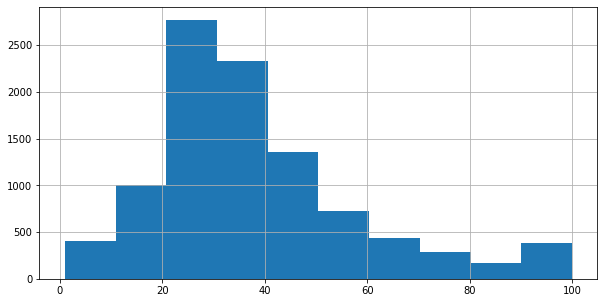

In [ ]:
train_df = pd.read_csv(clean_dataset_path/'train.csv')
train_df.head()

train_df['path'] = train_df['Id'].map(lambda x:str(clean_dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

len_df = len(train_df)
print(f"There are {len_df} images")

train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")

print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")

578 960


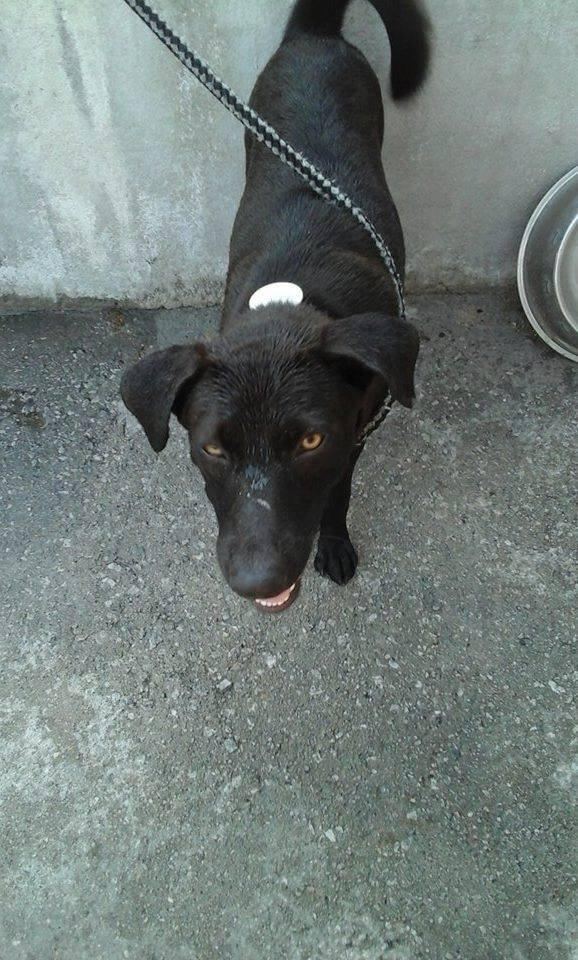

In [ ]:
train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']

im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height)

im

In [ ]:
# SRC_PATH = "/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest/Input/swin-transformer/swin-transformer.zip"
# DST_PATH = "/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest/Input/swin-transformer/"

# !unzip $SRC_PATH -d $DST_PATH 

In [ ]:
# if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
#     os.makedirs('/root/.cache/torch/hub/checkpoints/')
# # !cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

# !cp '/content/drive/MyDrive/kaggle/PetFinder-Pawpularity-Contest/Input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

In [ ]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

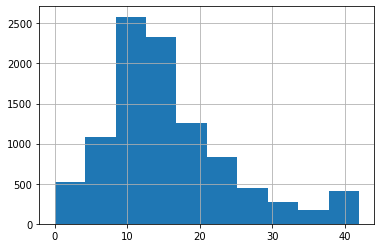

In [ ]:
import math

#Sturges' rule
# num_bins = int(np.floor(1+np.log2(len(train_df))))
# num_bins

#Rice rule
num_bins = int(np.ceil(2*((len(train_df))**(1./3))))
num_bins

train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

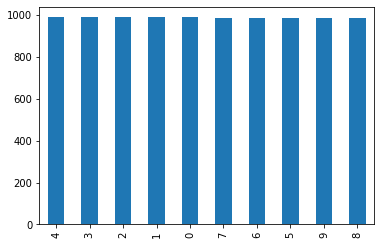

In [ ]:
#from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1

N_FOLDS = 10

strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')
train_df.fold.value_counts().plot.bar()
# train_df[train_df['fold']==0].head()
# train_df[train_df['fold']==0]['bins'].value_counts()
# train_df[train_df['fold']==1]['bins'].value_counts()

In [ ]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [ ]:
def get_data(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    #mixup_fn = Mixup(**mixup_args)
    
#     dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
# #                                valid_pct=0.2, #80-20 train-validation random split
#                                valid_col='is_valid', #
#                                seed=999, #seed
#                                fn_col='path', #filename/path is in the second column of the DataFrame
#                                label_col='norm_score', #label is in the first column of the DataFrame
#                                y_block=RegressionBlock, #The type of target
#                                bs=BATCH_SIZE, #pass in batch size
#                                num_workers=8,
#                                item_tfms=Resize(224), #pass in item_tfms
#                                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    # It looks if seed of RandomSplitter is set, it reduce the score. So we don't set seed here
    splitter = RandomSplitter(0.1)
    # Change RandomSplitter to IndexSplitter
    splitter = IndexSplitter(splitter(range(len(train_df)))[1])
    dls = DataBlock(blocks=(ImageBlock, RegressionBlock),
                get_x=ColReader('path'),
                get_y=ColReader('norm_score'),
                splitter=splitter,
                item_tfms=Resize(224), #pass in item_tfms
                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])
               )
    
    paw_dls = dls.dataloaders(train_df_f, 
                          bs=BATCH_SIZE,
                          num_workers=8,
                          seed=seed)
    
    return paw_dls, splitter

In [ ]:
def get_learner(fold_num):
    data, splitter = get_data(fold_num)
    
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse, cbs=[MixUp(0.2)]).to_fp16()
    
    return learn, splitter

In [ ]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [ ]:
if len(test_df) != 8:
    NEED_TRAIN = True

test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

In [ ]:
wandb.init(project='PetFinder.my-Pawpularity-Contest');

wandb: Currently logged in as: ao9mame (use `wandb login --relogin` to force relogin)


Fold 0 results


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth


WandbCallback could not retrieve the dataset path, please provide it explicitly to "log_dataset"


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.657215,0.647308,18.180447,08:51
1,0.648438,0.639866,17.226175,06:54
2,0.640973,0.637038,16.855736,06:54
3,0.639507,0.636805,16.815516,06:56
4,0.639176,0.636354,16.756140,06:56


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


WandbCallback was not able to get prediction samples -> "clamp_scalar_cpu" not implemented for 'Bool'
Better model found at epoch 0 with valid_loss value: 0.6473084092140198.
Better model found at epoch 1 with valid_loss value: 0.6398655772209167.
Better model found at epoch 2 with valid_loss value: 0.6370375752449036.
Better model found at epoch 3 with valid_loss value: 0.6368052363395691.
Better model found at epoch 4 with valid_loss value: 0.6363541483879089.


1812    27
2117    31
3350    13
7730    16
958     54
Name: Pawpularity, dtype: int64 TensorImage([[0.2805],
        [0.5925],
        [0.3783],
        [0.3681],
        [0.4959]])
Fold 0 | Score: 16.943969903169148
CV Score: 16.943969903169148


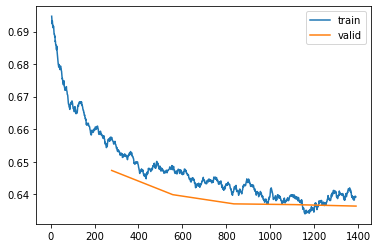

In [ ]:
import gc

from sklearn.metrics import mean_squared_error

if NEED_TRAIN:
    all_preds = []
    train_df['pred'] = -1

    for i in range(N_FOLDS):

        print(f'Fold {i} results')

        learn, splitter = get_learner(fold_num=i)
        
#         mixup_args = {
#             'mixup_alpha': 1.,
#             'cutmix_alpha': 0.,
#             'cutmix_minmax': None,
#             'prob': 1.0,
#             'switch_prob': 0.,
#             'mode': 'batch',
#             'label_smoothing': 0,
#             'num_classes': 100}
        
#         mixup_fn = Mixup(**mixup_args)

        learn.fit_one_cycle(5, 2e-5, cbs=[WandbCallback(log_dataset=True, log_model=True), SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 

        learn.recorder.plot_loss()
        
        #over fitting
#         learn.unfreeze()
        
#         learn.fit_one_cycle(5,lr_max=slice(1e-6,1e-4))

        #learn = learn.to_fp32()

        # todo: バグが起きたのでとりあえずコメントアウト
        # learn.export(f'model_fold_{i}.pkl')
        #learn.save(f'model_fold_{i}.pkl')

#         dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
#                                    valid_pct=0.2, #80-20 train-validation random split
#                                    seed=999, #seed
#                                    fn_col='path', #filename/path is in the second column of the DataFrame
#                                    label_col='norm_score', #label is in the first column of the DataFrame
#                                    y_block=RegressionBlock, #The type of target
#                                    bs=BATCH_SIZE, #pass in batch size
#                                    num_workers=8,
#                                    item_tfms=Resize(224), #item_tfms=RandomResizedCrop(224, min_scale=0.3) #pass in item_tfms
#                                    batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 

        dls = DataBlock(blocks=(ImageBlock, RegressionBlock),
                    get_x=ColReader('path'),
                    get_y=ColReader('norm_score'),
                    splitter=RandomSplitter(0.2),
                    item_tfms=Resize(224), #pass in item_tfms
                    batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])
                   )

        paw_dls = dls.dataloaders(train_df, 
                              bs=BATCH_SIZE,
                              num_workers=8,
                          seed=seed)
        
        test_dl = paw_dls.test_dl(test_df)

        preds, _ = learn.tta(dl=test_dl, n=5, beta=0)

        all_preds.append(preds)
        
        val_idx = splitter(range(len(train_df)))[1]
        val_df = train_df.loc[val_idx]
        val_pred, _ = learn.tta(dl=paw_dls.test_dl(val_df), n=5, beta=0)
        print(val_df['Pawpularity'][:5], val_pred[:5])
        score = mean_squared_error(val_df['Pawpularity'], val_pred*100, squared=False)
        print(f'Fold {i} | Score: {score}')
        # Save prediction of validation as pred
        train_df.loc[val_idx, 'pred'] = val_pred*100

        del learn

        torch.cuda.empty_cache()

        gc.collect()
        
        #Only run one fold for public train as we don't have so many GPU time
        if len(test_df) == 8:
            break
    if len(test_df) == 8:
        cv_score = mean_squared_error(train_df.loc[train_df['pred']!=-1, 'Pawpularity'], 
                                      train_df.loc[train_df['pred']!=-1, 'pred'], squared=False)
        print(f'CV Score: {cv_score}')

In [ ]:
if NEED_TRAIN:
    all_preds, np.mean(np.stack(all_preds*100))

sample_df = pd.read_csv(dataset_path/'sample_submission.csv')

In [ ]:
if NEED_TRAIN:
    preds = np.mean(np.stack(all_preds), axis=0)
    sample_df['Pawpularity'] = preds*100

sample_df.to_csv('submission.csv',index=False)
sample_df

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,45.002518
1,43a2262d7738e3d420d453815151079e,45.520355
2,4e429cead1848a298432a0acad014c9d,45.714996
3,80bc3ccafcc51b66303c2c263aa38486,45.873337
4,8f49844c382931444e68dffbe20228f4,47.806778
5,b03f7041962238a7c9d6537e22f9b017,46.333633
6,c978013571258ed6d4637f6e8cc9d6a3,45.321102
7,e0de453c1bffc20c22b072b34b54e50f,45.689114


In [ ]:
if not NEED_TRAIN:
    pd.read_csv('submission.csv').head()

In [ ]:
# optional: mark the run as completed
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
petfinder_rmse,█▃▁▁▁
raw_loss,█▆▃█▅▅▇▇▃▇▇▄▁▅▄▆▇▆▅▅▅▇▃▄▁▇▄▄▆▅▆▅▃▅▅▁▅▃▂▄
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▅▅▄▄▃▄▃▃▃▂▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▂▂▂
valid_loss,█▃▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,5
